In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
df_both = pd.read_csv('df_both.csv')

In [3]:
feat_set = ['PRCP', 'TMAX',
            'TMIN']

target_var = 'outcome'

In [4]:
cycle_0_11 = stb.graphs.cycle_int_graph(0,11)

In [5]:
train_size_vec = [500,1000, 2000, 5000, 10000]
valid_size = 5000
test_size = 25000
md_range = [2,3,4]
singleton_weight_vec = np.arange(1,10)/10
num_trials=5

llmat_str_w_fixed = np.zeros((len(singleton_weight_vec), num_trials, len(md_range), len(train_size_vec)))
llmat_str_w_random = np.zeros((len(singleton_weight_vec), num_trials, len(md_range), len(train_size_vec)))
llmat_no_str = np.zeros((num_trials, len(md_range), len(train_size_vec)))
for kk, train_size in enumerate(train_size_vec):
    for j in range(num_trials):        
        df_small = df_both.sample(test_size+valid_size+train_size, random_state=j).reset_index(drop=True).copy()
        X = df_small.loc[:,feat_set].copy()
        y = df_small[target_var].copy()
        X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=j+1)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=j+2)
        X_train.shape, X_valid.shape, X_test.shape
        fc1 = stb.get_basic_config(X_train, stb.default_config_dict())

        for zzz,md in enumerate(md_range):
            gbmstr0 = stb.StructureBoostMulti(num_trees=5000, learning_rate=.02,
                                          feature_configs=fc1, num_classes=12, max_depth=md)

            gbmstr0.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=2)

            pred_probs_gbstr0 = gbmstr0.predict_proba(X_test)
            llmat_no_str[j,zzz,kk] = log_loss(y_test, pred_probs_gbstr0)  

        for i,sw in enumerate(singleton_weight_vec):   
            print('train size {}'.format(train_size))
            print('trial num {}'.format(j))
            print('singleton weight {}'.format(sw))
            ts1 = {}
            ts1['singleton_weight'] = sw
            ts1['partition_list'] = [
                [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                [[2,3,4],[5,6,7],[8,9,10],[11,0,1]]    
            ]
            rem = (1-ts1['singleton_weight'])/3
            ts1['partition_weight_vec'] = [rem,rem,rem]

            ts2 = {}
            ts2['singleton_weight'] = sw
            ts2['random_partition_size'] = 4
            ts2['partition_list'] = 'random'
            ts2['target_graph']= cycle_0_11



            for zzz,md in enumerate(md_range):
                gbmstr1 = stb.StructureBoostMulti(num_trees=5000, target_structure=ts1, learning_rate=.02,
                                              feature_configs=fc1, num_classes=12, max_depth=md)

                gbmstr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=2)

                pred_probs_gbstr1 = gbmstr1.predict_proba(X_test)
                llmat_str_w_fixed[i,j,zzz,kk] = log_loss(y_test, pred_probs_gbstr1)
            for zzz,md in enumerate(md_range):
                gbmstr2 = stb.StructureBoostMulti(num_trees=5000, target_structure=ts2, learning_rate=.02,
                                              feature_configs=fc1, num_classes=12, max_depth=md)

                gbmstr2.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=2)

                pred_probs_gbstr2 = gbmstr2.predict_proba(X_test)
                llmat_str_w_random[i,j,zzz,kk] = log_loss(y_test, pred_probs_gbstr2)




i=0, eval_set_log_loss = 2.5017682116652495
i=10, eval_set_log_loss = 2.4233861237036955
i=20, eval_set_log_loss = 2.3696159636247205
i=30, eval_set_log_loss = 2.33149231755416
i=40, eval_set_log_loss = 2.3037732408685954
i=50, eval_set_log_loss = 2.28269798837124
i=60, eval_set_log_loss = 2.2663056425961554
i=70, eval_set_log_loss = 2.2537816037252867
i=80, eval_set_log_loss = 2.244653215146274
i=90, eval_set_log_loss = 2.2378958015352963
i=100, eval_set_log_loss = 2.233105241552916
i=110, eval_set_log_loss = 2.2291139779750555
i=120, eval_set_log_loss = 2.226522479722141
i=130, eval_set_log_loss = 2.2256906520742943
i=140, eval_set_log_loss = 2.224552927302251
i=150, eval_set_log_loss = 2.2232130856242227
i=160, eval_set_log_loss = 2.2235937424014263
i=170, eval_set_log_loss = 2.2226882840903257
i=180, eval_set_log_loss = 2.2236980710816905
Stopping early: curr_loss of 2.2236980710816905
                                        exceeds compare_loss of 2.2232130856242227
i=0, eval_set_

In [6]:
strvec_w_fixed_500 = np.min(np.mean(llmat_str_w_fixed[:,:,:,0], axis=1), axis=1)
strvec_w_random_500 = np.min(np.mean(llmat_str_w_random[:,:,:,0], axis=1), axis=1)
no_str_val_500 = np.min(np.mean(llmat_no_str[:,:,0], axis=0), axis=0)

strvec_w_fixed_1k = np.min(np.mean(llmat_str_w_fixed[:,:,:,1], axis=1), axis=1)
strvec_w_random_1k = np.min(np.mean(llmat_str_w_random[:,:,:,1], axis=1), axis=1)
no_str_val_1k = np.min(np.mean(llmat_no_str[:,:,1], axis=0), axis=0)

strvec_w_fixed_2k = np.min(np.mean(llmat_str_w_fixed[:,:,:,2], axis=1), axis=1)
strvec_w_random_2k = np.min(np.mean(llmat_str_w_random[:,:,:,2], axis=1), axis=1)
no_str_val_2k = np.min(np.mean(llmat_no_str[:,:,2], axis=0), axis=0)

strvec_w_fixed_5k = np.min(np.mean(llmat_str_w_fixed[:,:,:,3], axis=1), axis=1)
strvec_w_random_5k = np.min(np.mean(llmat_str_w_random[:,:,:,3], axis=1), axis=1)
no_str_val_5k = np.min(np.mean(llmat_no_str[:,:,3], axis=0), axis=0)

strvec_w_fixed_10k = np.min(np.mean(llmat_str_w_fixed[:,:,:,4], axis=1), axis=1)
strvec_w_random_10k = np.min(np.mean(llmat_str_w_random[:,:,:,4], axis=1), axis=1)
no_str_val_10k = np.min(np.mean(llmat_no_str[:,:,4], axis=0), axis=0)



In [7]:
np.save('llmat_str_w_fixed.npy',llmat_str_w_fixed)
np.save('llmat_str_w_random.npy',llmat_str_w_random)
np.save('llmat_no_str.npy',llmat_no_str)

(2.2035964999799886, 2.2307168974889917)

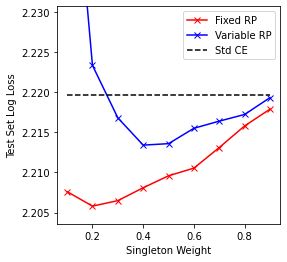

In [8]:
plt.figure(figsize=(4,4))
plt.plot(singleton_weight_vec, strvec_w_fixed_500, label='Fixed RP', color='red', marker ='x')
plt.plot(singleton_weight_vec, strvec_w_random_500, label='Variable RP', color='blue', marker ='x')
plt.plot(singleton_weight_vec, no_str_val_500*np.ones(len(singleton_weight_vec)), label='Std CE',
         color='k', linestyle='--')
plt.xlabel('Singleton Weight')
plt.ylabel('Test Set Log Loss')
plt.legend()
plt.ylim([np.min(strvec_w_fixed_500*.999),no_str_val_500*1.005])

(2.172438172636838, 2.195477662543974)

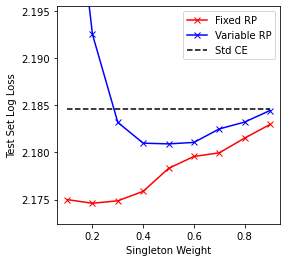

In [9]:
plt.figure(figsize=(4,4))
plt.plot(singleton_weight_vec, strvec_w_fixed_1k, label='Fixed RP', color='red', marker ='x')
plt.plot(singleton_weight_vec, strvec_w_random_1k, label='Variable RP', color='blue', marker ='x')
plt.plot(singleton_weight_vec, no_str_val_1k*np.ones(len(singleton_weight_vec)), label='Std CE',
         color='k', linestyle='--')
plt.xlabel('Singleton Weight')
plt.ylabel('Test Set Log Loss')
plt.legend()
plt.ylim([np.min(strvec_w_fixed_1k*.999),no_str_val_1k*1.005])

(2.1528552242852634, 2.174063561490503)

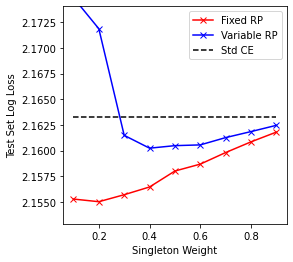

In [10]:
plt.figure(figsize=(4,4))
plt.plot(singleton_weight_vec, strvec_w_fixed_2k, label='Fixed RP', color='red', marker ='x')
plt.plot(singleton_weight_vec, strvec_w_random_2k, label='Variable RP', color='blue', marker ='x')
plt.plot(singleton_weight_vec, no_str_val_2k*np.ones(len(singleton_weight_vec)), label='Std CE',
         color='k', linestyle='--')
plt.xlabel('Singleton Weight')
plt.ylabel('Test Set Log Loss')
plt.legend()
plt.ylim([np.min(strvec_w_fixed_2k*.999),no_str_val_2k*1.005])

(2.1410129758276697, 2.157875107758515)

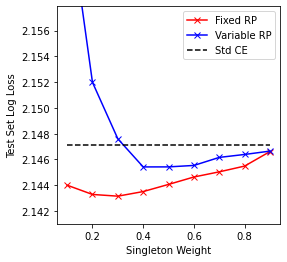

In [11]:
plt.figure(figsize=(4,4))
plt.plot(singleton_weight_vec, strvec_w_fixed_5k, label='Fixed RP', color='red', marker ='x')
plt.plot(singleton_weight_vec, strvec_w_random_5k, label='Variable RP', color='blue', marker ='x')
plt.plot(singleton_weight_vec, no_str_val_5k*np.ones(len(singleton_weight_vec)), label='Std CE',
         color='k', linestyle='--')
plt.xlabel('Singleton Weight')
plt.ylabel('Test Set Log Loss')
plt.legend()
plt.ylim([np.min(strvec_w_fixed_5k*.999),no_str_val_5k*1.005])

(2.132143635749726, 2.1469738202812487)

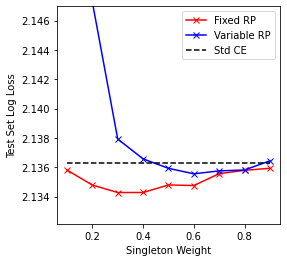

In [13]:
plt.figure(figsize=(4,4))
plt.plot(singleton_weight_vec, strvec_w_fixed_10k, label='Fixed RP', color='red', marker ='x')
plt.plot(singleton_weight_vec, strvec_w_random_10k, label='Variable RP', color='blue', marker ='x')
plt.plot(singleton_weight_vec, no_str_val_10k*np.ones(len(singleton_weight_vec)), label='Std CE',
         color='k', linestyle='--')
plt.xlabel('Singleton Weight')
plt.ylabel('Test Set Log Loss')
plt.legend()
plt.ylim([np.min(strvec_w_fixed_10k*.999),no_str_val_10k*1.005])